<h1> DKT Model for ASSISSTMENT </h1>
<p> This notebook is for creating RNN model for generating output vector as a feature for predicting student's property </p>

<i>
DKT Model Code for this project is based on: https://github.com/davidoj/deepknowledgetracingTF
</i>

In [21]:
import pandas as pd
import numpy as np
import os
import sys
import csv
import collections
import tensorflow as tf
from sklearn.metrics import roc_auc_score

<h1> Data Processing Block </h1>
<p> Student logs, including training and validation set, are loaded into the notebook in pandas dataframe. After loading, useful columns are extracted and stored into the following:</p>
<h3>Variables</h3>
<ul>
    <li> 
        <b>training_label_df, validation_test_label, student_df</b>: Includes all columns from the original file 
    </li>
    <li>
        <b>student_df_dkt</b>: Columns <i>"ITEST_id", "skill", "actionId" and "correct"</i> are extracted. All records with same ITEST_id are gathered togethered and sorted in ascending order with respect to actionId.
    </li>
    <li> 
        <b>skill_list</b>: All skills included in the student records are extracted. It <b>MUST</b> be used for onehot encoding later to maintain encoding consistency. <b><i>[!IMPORTANT]</i></b>
    </li>
    <li>
        <b>id_entrynum</b>: A dictionary with ITESTId(Key), num entry(value), sorted by ITESTId
    </li>
</ul>

<h3>Functions</h3>

<b>student_dkt_data(data, skill_list=skill_list, id_entrynum=id_entrynum)</b>
<ul>
    <li> data: student_df_dkt in pandas dataframe sorted in ITEST_id and actionId </li>
    <li> skill_list: The list stored all skills in a given order </li>
    <li> id_entrynum: a dictionary sorted in ITESTId with value on num of entries per ITESTId </li>
    <li> Output[i]: [# of questions answer of student i, (skills of questions, correctness of the answer)] </li>
</ul>

<i>Last update: 31/10/2017 </i>

In [24]:
# Data preparation
# Merge student logs into pandas data frame
data_dir = './data/'

student_log_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('student_log')]
training_label_path = os.path.join(data_dir, 'training_label.csv')
validation_test_label = os.path.join(data_dir, 'validation_test_label.csv')

dfs = []
for path in student_log_paths:
    temp = pd.read_csv(path)
    dfs.append(temp)
student_df = pd.concat(dfs)

training_label_df = pd.read_csv(training_label_path)
validation_test_label_df = pd.read_csv(validation_test_label)
student_df = student_df[student_df.scaffold == 0]

student_df_dkt_static = student_df[['ITEST_id', 'AveKnow', 'AveCarelessness', 'AveCorrect', 'AveResBored', 'AveResEngcon', 'AveResConf' , 'AveResFrust', 'AveResOfftask', 'AveResGaming']]
student_df_dkt_dynamic = student_df[['ITEST_id', 'skill', 'actionId', 'correct', 'hint', 'hintCount', 'hintTotal']]
student_df_dkt_static = student_df_dkt_static.drop_duplicates()
# Please do not modify this one. This will be the skill_list used throughout the whole training
skill_list = student_df_dkt_dynamic.skill.unique()

#Sort student_df according to ITESTId then actionId
student_df_dkt_dynamic.sort_values(["ITEST_id","actionId"], inplace=True, ascending=True)

# Create a dictionary with ITESTId(Key), num entry(value), sorted by ITESTId
id_entrynum = student_df_dkt_dynamic.groupby('ITEST_id').nunique()['actionId'].to_dict()
id_entrynum = collections.OrderedDict(sorted(id_entrynum.items()))

C:\Users\Public\Anaconda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Public\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
print(student_df_dkt_static)
skill_list_index= dict(zip(range(len(skill_list)),skill_list))
print(skill_list_index)

       ITEST_id   AveKnow  AveCarelessness  AveCorrect  AveResBored  \
0             8  0.352416         0.183276    0.483902     0.208389   
1056         35  0.255164         0.158848    0.379658     0.222796   
2049         39  0.281693         0.152227    0.454545     0.274700   
2467         64  0.157938         0.098357    0.334038     0.198394   
3886         77  0.191948         0.094195    0.413249     0.261455   
4203        126  0.250838         0.111159    0.500000     0.273188   
4609        134  0.183801         0.113211    0.323420     0.267901   
4878        156  0.271432         0.183643    0.384766     0.255130   
5390        160  0.222439         0.146000    0.387009     0.234373   
6129        164  0.117598         0.081440    0.256983     0.252204   
6308        205  0.229988         0.126401    0.445407     0.242691   
6885        215  0.313221         0.184542    0.475655     0.257214   
7419        243  0.388355         0.218368    0.566243     0.251760   
7970  

In [26]:
def student_dkt_data(data, skill_list=skill_list, id_entrynum=id_entrynum):
    # Input:
    # data - student_df_dkt in pandas dataframe sorted in ITEST_id and actionId
    # skill_list - the list stored all skills in a give order
    # id_entrynum - a dictionary sorted in ITESTId with value on num of entries per ITESTId
    # Output - Output[i] = [# of questions answer of student i, skills of questions, correctness of the answer]
    v = []
    # temporary function for converting skill into a number representing that skills (need to do oneshot later)
    f = lambda x: np.where(skill_list == x)[0][0] 
    for key, value in id_entrynum.items():
        skill = list(map(f, data[data['ITEST_id'] == key]['skill'].values))
        correct = data[data['ITEST_id'] == key]['correct'].values.tolist()
        v.append((key, np.asscalar(value), list(zip(skill, correct))))
    return v
        

In [34]:
import pickle

with open("assisstment_dynamic.pkl", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
with open("assisstment_static.pkl", "rb") as fp:   # Unpickling
    c = pickle.load(fp)
with open("assisstment_skill.pkl", "rb") as fp:   # Unpickling
    d = pickle.load(fp)
    
print(b[['ITEST_id', 'correct', 'skill']])

FileNotFoundError: [Errno 2] No such file or directory: 'assisstment_dynamic.pkl'

In [42]:
student_df_dkt[student_df_dkt['ITEST_id'] == 8]['ITEST_id']

0       8
1       8
2       8
3       8
4       8
5       8
6       8
7       8
8       8
9       8
10      8
11      8
12      8
13      8
14      8
15      8
16      8
17      8
18      8
19      8
20      8
21      8
22      8
23      8
24      8
25      8
26      8
27      8
28      8
29      8
       ..
1026    8
1027    8
1028    8
1029    8
1030    8
1031    8
1032    8
1033    8
1034    8
1035    8
1036    8
1037    8
1038    8
1039    8
1040    8
1041    8
1042    8
1043    8
1044    8
1045    8
1046    8
1047    8
1048    8
1049    8
1050    8
1051    8
1052    8
1053    8
1054    8
1055    8
Name: ITEST_id, Length: 1056, dtype: int64

<h1> Model Definition </h1>
<p> Here are parameters of the model: </p>
<ul>
    <li><b>batch_size</b>: minibatch size</li>
    <li><b>num_probs</b>: number of unique problems in the dataset</li>
    <li><b>embedding_size</b>: size of the embedding lookup layer</li>
    <li><b>num_hid</b>: number of units in the single hidden layer</li>
    <li><b>initial_learning_rate</b>: learning rate of ADAM optmizer at first step of training</li>
    <li><b>epsilon</b>: epsilon parameter of ADAM optimizer</li>
    <li><b>final_learning_rate</b>: learning rate after 3000 training steps (linear decay)</li>
    <li><b>keep_prob</b>: keep probability for dropout layer</li>
</ul>

In [5]:
class Model:
    def __init__(   
            self,
            batch_size,
            num_probs,
            embedding_size=250,
            num_hid=250,
            initial_learning_rate=0.001,
            final_learning_rate=0.001,
            keep_prob=1,
            epsilon=0.00001):
        """Create an LSTM for test score prediction
        Args:
            batch_size: minibatch size
            num_probs: number of unique problems in the dataset
            embedding_size: size of the embedding lookup layer
            num_hid: number of units in the single hidden layer
            initial_learning_rate: learning rate of ADAM optmizer at first step of training
            epsilon: epsilon parameter of ADAM optimizer
            final_learning_rate: learning rate after 3000 training steps (linear decay)
            keep_prob: keep probability for dropout layer
        Returns:
            tuple: (optimizer, training_loss, validation_prediction)
        """

        # Inputs
        Xs = self._Xs = tf.placeholder(tf.int32, shape=[batch_size, None])
        Ys = self._Ys = tf.placeholder(tf.float32, shape=[batch_size, None, num_probs])
        targets = self._targets = tf.placeholder(tf.float32, shape=[batch_size, None])
        sequence_length = self._seqlen = tf.placeholder(tf.int32, shape=[batch_size])

        # Global parameters
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.polynomial_decay(initial_learning_rate, global_step,5000,final_learning_rate)

        # LSTM parameters
        w = tf.Variable(tf.truncated_normal([num_hid, num_probs],stddev=1.0/np.sqrt(num_probs)))
        b = tf.Variable(tf.truncated_normal([num_probs],stddev=1.0/np.sqrt(num_probs)))
        embeddings = tf.Variable(tf.random_uniform([2*num_probs+2, embedding_size], -1.0, 1.0))
        cell = tf.nn.rnn_cell.BasicLSTMCell(num_hid)
        initial_state = cell.zero_state(batch_size,tf.float32)

        # LSTM Training ops
        inputsX = tf.nn.embedding_lookup(embeddings,Xs)
        outputs, state = tf.nn.dynamic_rnn(cell,inputsX,sequence_length,initial_state=initial_state)
        if keep_prob != 1:
            outputs = tf.nn.dropout(outputs, keep_prob)
        outputs_flat = tf.reshape(outputs,shape=[-1,num_hid])
        logits = tf.reshape(tf.nn.xw_plus_b(outputs_flat, w, b),shape=[batch_size,-1,num_probs])
        self._pred_run = pred = tf.reduce_max(logits * Ys, axis=2)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=targets)
        mask = tf.sign(tf.abs(pred))
        loss_masked = mask*loss
        loss_masked_by_s = tf.reduce_sum(loss_masked, axis=1)
        mean_loss = self._loss = tf.reduce_mean(loss_masked_by_s/tf.to_float(sequence_length))

        # Optimizer
        optimizer = self._train = tf.train.AdamOptimizer(learning_rate=learning_rate,
            epsilon=epsilon).minimize(mean_loss,global_step=global_step)
        
        saver = self._saver = tf.train.Saver()

        # LSTM Validation ops
        test_outputs, test_state = tf.nn.dynamic_rnn(cell,inputsX,sequence_length,initial_state)
        test_outputs_flat = tf.reshape(test_outputs, shape=[-1,num_hid])
        test_logits = tf.reshape(tf.nn.xw_plus_b(test_outputs_flat,w,b),shape=[batch_size,-1,num_probs])
        test_pred = self._pred = tf.sigmoid(tf.reduce_sum(test_logits*Ys, axis=2))
    
    @property
    def Xs(self):
        return self._Xs

    @property
    def Ys(self):
        return self._Ys

    @property
    def targets(self):
        return self._targets

    @property
    def seq_len(self):
        return self._seqlen

    @property
    def loss(self):
        return self._loss

    @property
    def train_op(self):
        return self._train

    @property
    def predict(self):
        return self._pred
    
    @property
    def predict_run(self):
        return self._pred_run
    
    @property
    def saver(self):
        return self._saver

<h1>Batch Generation</h1>
<p>The following functions blocks are used for batch generation.</p>
<h3>skill_onehot(skill, skill_length)</h3>
<ul>
    <li>
        <b>skill</b>: the single type of skill wanted to be encoded, the number representing the skill is generated with respect to skill_list.
    </li>
     <li>
         <b>skill_length</b>: the number of skill present in the dataset with respect to skill_list
     </li>
</ul>
<h3>BatchGenerator <i>(class)</i></h3>
<ul>
    <h3>__init__(self,data,batch_size,skill_list,max_len)</h3>
    
     <li><b>data</b>: 

In [6]:
def skill_onehot(skill, skill_length):
    # skill - the single type of skill wanted to be encoded
    # skill_length - the total number of skills in the problem space
    # return - an onehot vector of the input skill with size skill_length 
    v = np.zeros((skill_length,))
    v[skill] = 1
    return v

class BatchGenerator:

    def __init__(self,data,batch_size,skill_list,max_len=3500):
        """
        Args:
            data: score data in the format [[sequence_length, [(problem_id, success_or_fail)]]]
                    each sequence is a different test taker
                    list of test scores is in temporal order
            batch_size: minibatch size to serve
            max_len: the longest sequence of responses to keep
        """
        self.data = sorted(data, key = lambda x: len(x[1]))
        self.cursor = 0
        self.batch_size = batch_size
        self.max_len = max_len
        self.num_probs = len(skill_list)
        self.n = len(data)
            
    def next_batch(self):
        tups = []
        n_samps = []
        for i in range(self.batch_size):
            tups.append(self.data[self.cursor][1][:self.max_len])            
            n_samps.append(len(tups[-1]))
            self.cursor = (self.cursor + 1) % len(self.data)
        #print("tups:", tups)
        mlen = max(n_samps)
        Xs = np.zeros((self.batch_size, mlen),dtype=np.int32)
        Ys = np.zeros((self.batch_size, mlen, self.num_probs),dtype=np.int32)
        targets = np.zeros((self.batch_size, mlen),dtype=np.int32)
        for i, tuplist in enumerate(tups):
            Xs[i] = np.pad([2 + t[0] + t[1]*self.num_probs for t in tuplist[:-1]],
                (1,mlen-len(tuplist)),'constant',constant_values=(1,0))
            Ys[i] = np.pad([skill_onehot(t[0],self.num_probs) for t in tuplist],
                ((0,mlen-len(tuplist)),(0,0)),'constant',constant_values=0)
            #print([t[0] for t in tuplist])
            #print("hi")
            targets[i] = np.pad([t[1] for t in tuplist],(0,mlen-len(tuplist)),'constant',constant_values=0)
        if self.cursor == 0: 
            pass
            #print("Xs: ", Xs)
        return Xs, Ys, targets, n_samps

In [7]:
#Playground
#train_batches = BatchGenerator(train_data,1, skill_list)
#Xs, Ys, targets, n_samps = train_batches.next_batch()
#print(Ys)
        

In [31]:
def run(session, train_batchgen, test_batchgen, train_steps):

    m = Model(train_batchgen.batch_size,train_batchgen.num_probs)
    with session.as_default() as sess:
        tf.global_variables_initializer().run()
        print("Initialized")
        average_loss = 0
        for step in range(train_steps):
            batch_Xs, batch_Ys, batch_labels, batch_sequence_lengths = train_batches.next_batch()
            feed_dict = {m.Xs : batch_Xs, m.Ys : batch_Ys, 
                         m.seq_len : batch_sequence_lengths, m.targets : batch_labels}
            _, l, pred = session.run([m.train_op,m.loss, m.predict_run], feed_dict=feed_dict)
            #print(pred)
            average_loss += l
            if step % 5 == 0:
                average_loss = average_loss / min(100,step+1)
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
            if step % 5 == 0:
                auc = 0
                for i in range(test_batchgen.n//train_batchgen.batch_size):
                    test_batch_Xs, test_batch_Ys, test_batch_labels, test_batch_sequence_lengths = test_batchgen.next_batch()
                    test_feed_dict = {m.Xs : test_batch_Xs, m.Ys : test_batch_Ys, 
                                      m.seq_len : test_batch_sequence_lengths}
                    pred = session.run([m.predict], feed_dict=test_feed_dict)
                    if step == 50:
                        pass
                        #print(pred)
                    #print(pred)
                    auc += roc_auc_score(test_batch_labels.reshape(-1),np.array(pred).reshape(-1))/(test_batchgen.n//train_batchgen.batch_size)
                print("AUC Score: ", auc)
                save_path = m.saver.save(session, './model.ckpt')
                print('Model saved in {}'.format(save_path))

<h1> Run Model </h1>

In [23]:
# Process the data from student_df by student_dkt_data
data = student_dkt_data(student_df_dkt)

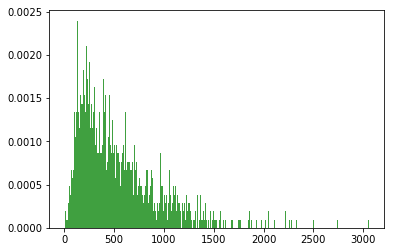

In [50]:
import matplotlib.pyplot as plt
v0 = 0
v1 = []
for key, value in id_entrynum.items():
    v1.append(value)
plt.hist(v1, 500, normed=1, facecolor='green', alpha=0.75)
plt.show()


In [25]:
###########################################
# Training Data and Test Data Preparation #
###########################################
TRAINING_RATIO = 0.8
VALIDATION_RATIO = 0.2
train_data = data[:int(len(data)*TRAINING_RATIO)]
test_data = data[int(len(data)*TRAINING_RATIO):]

In [26]:
##########################
# Hyperparameter Setting #
##########################
BATCH_SIZE = 100
TRAIN_STEPS = 100


In [32]:
##############
# RUN MODEL #
#############

tf.reset_default_graph()

train_batches = BatchGenerator(train_data,BATCH_SIZE, skill_list)
test_batches = BatchGenerator(test_data,BATCH_SIZE, skill_list)

s = tf.Session()

run(s, train_batches, test_batches, TRAIN_STEPS)

Initialized
Average loss at step 0: 0.301429
AUC Score:  0.583921725905
Model saved in ./model.ckpt
Average loss at step 5: 0.136764
AUC Score:  0.574665880078
Model saved in ./model.ckpt
Average loss at step 10: 0.061589
AUC Score:  0.580600620694
Model saved in ./model.ckpt


KeyboardInterrupt: 